In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score,recall_score,f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
# 각 열별 결측치 개수 확인
null_counts_by_column = data.isnull().sum()
print("각 열별 결측치 개수:\n", null_counts_by_column)

각 열별 결측치 개수:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [5]:
# 전처리 다중 범주형 
df = pd.get_dummies(data, columns=["ChestPainType"])
df = pd.get_dummies(df, columns=["RestingECG"])
df = pd.get_dummies(df, columns=["ST_Slope"])
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   Sex                918 non-null    object 
 2   RestingBP          918 non-null    int64  
 3   Cholesterol        918 non-null    int64  
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    int64  
 6   ExerciseAngina     918 non-null    object 
 7   Oldpeak            918 non-null    float64
 8   HeartDisease       918 non-null    int64  
 9   ChestPainType_ASY  918 non-null    bool   
 10  ChestPainType_ATA  918 non-null    bool   
 11  ChestPainType_NAP  918 non-null    bool   
 12  ChestPainType_TA   918 non-null    bool   
 13  RestingECG_LVH     918 non-null    bool   
 14  RestingECG_Normal  918 non-null    bool   
 15  RestingECG_ST      918 non-null    bool   
 16  ST_Slope_Down      918 non

In [6]:
# 전처리 - 이진
map_Sex = { "M": 0, "F": 1 }
map_ExerciseAngina = { "N": 0, "Y": 1 }

df["Sex"] = df["Sex"].map(map_Sex)
df["ExerciseAngina"] = df["ExerciseAngina"].map(map_ExerciseAngina)
df.head()
df.info()
len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   Sex                918 non-null    int64  
 2   RestingBP          918 non-null    int64  
 3   Cholesterol        918 non-null    int64  
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    int64  
 6   ExerciseAngina     918 non-null    int64  
 7   Oldpeak            918 non-null    float64
 8   HeartDisease       918 non-null    int64  
 9   ChestPainType_ASY  918 non-null    bool   
 10  ChestPainType_ATA  918 non-null    bool   
 11  ChestPainType_NAP  918 non-null    bool   
 12  ChestPainType_TA   918 non-null    bool   
 13  RestingECG_LVH     918 non-null    bool   
 14  RestingECG_Normal  918 non-null    bool   
 15  RestingECG_ST      918 non-null    bool   
 16  ST_Slope_Down      918 non

918

In [7]:
# 타겟 분리
X = df.drop(columns=['HeartDisease'], axis=1)
y = df['HeartDisease']
# y
X.head()
# X.info()
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 918 entries, 0 to 917
Series name: HeartDisease
Non-Null Count  Dtype
--------------  -----
918 non-null    int64
dtypes: int64(1)
memory usage: 7.3 KB


In [8]:
# 2. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [9]:
# 모델 선언
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss') # 
# 학습
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
# 중요도 추출
importances = model.feature_importances_
# X_train.columns와 함께 정리
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

              Feature  Importance
17        ST_Slope_Up    0.514548
8   ChestPainType_ASY    0.113208
11   ChestPainType_TA    0.064070
1                 Sex    0.036124
15      ST_Slope_Down    0.034809
4           FastingBS    0.033727
6      ExerciseAngina    0.024607
12     RestingECG_LVH    0.023611
7             Oldpeak    0.022642
3         Cholesterol    0.020610
5               MaxHR    0.020324
16      ST_Slope_Flat    0.017810
0                 Age    0.016806
2           RestingBP    0.015246
9   ChestPainType_ATA    0.013300
10  ChestPainType_NAP    0.010087
13  RestingECG_Normal    0.009756
14      RestingECG_ST    0.008716


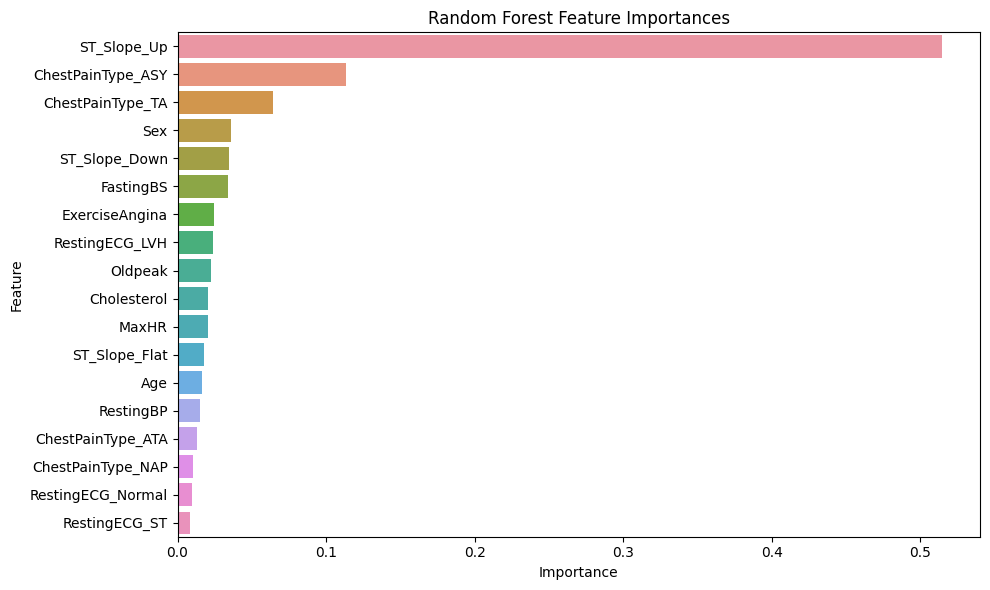

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [12]:
# 예측 확률
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [13]:
# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"정확도: {accuracy:.2f}")

# Precision, Recall, F1 Score 계산
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"정밀도 (Precision): {precision:.2f}")
print(f"재현율 (Recall): {recall:.2f}")
print(f"F1 스코어: {f1:.2f}")

# Specificity 계산 (TN / (TN + FP))
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"특이도 (Specificity): {specificity:.2f}")

정확도: 0.88
정밀도 (Precision): 0.90
재현율 (Recall): 0.88
F1 스코어: 0.89
특이도 (Specificity): 0.88


              precision    recall  f1-score   support

           0       0.85      0.88      0.86       123
           1       0.90      0.88      0.89       153

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276

ROC AUC: 0.9354375896700144


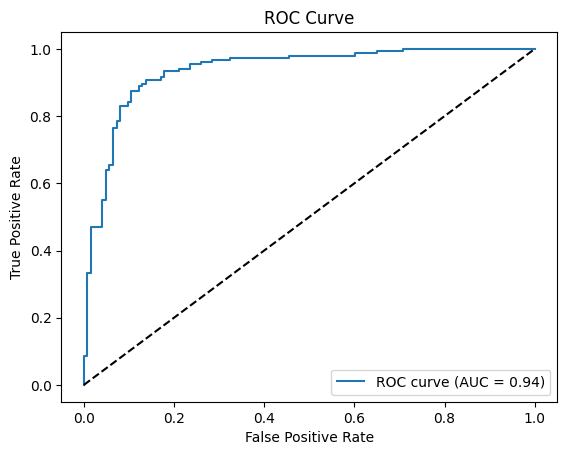

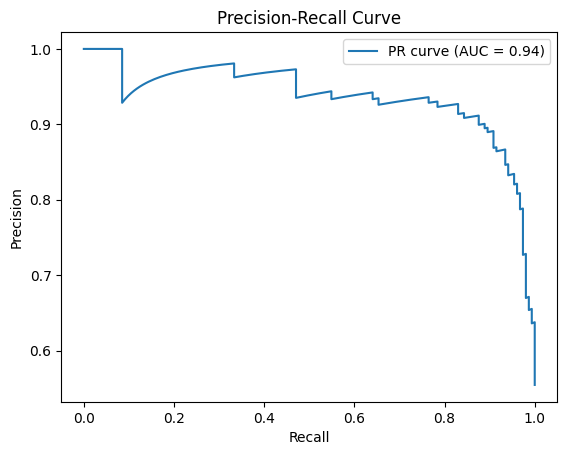

In [14]:
# 5. 평가 지표 출력
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 6. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 7. PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label="PR curve (AUC = {:.2f})".format(auc(recall, precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()